In [96]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [97]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [98]:
DATA_PATH = './data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 100
lr = 2e-4

In [99]:
dataset = dset.FashionMNIST(root="./data", download=True,
                     transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True, num_workers=2)

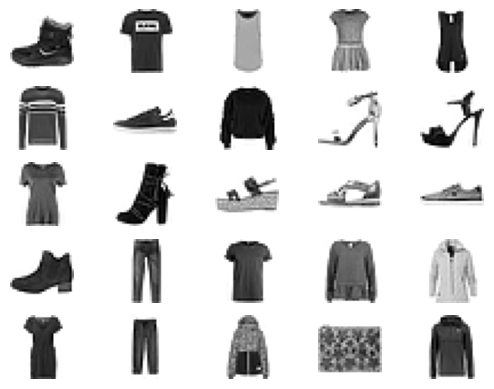

In [100]:
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis("off")
    plt.imshow(dataset.__getitem__(i)[0].reshape(28, 28), cmap="gray_r")
plt.show()

In [101]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [102]:
class Generator(nn.Module):
   def __init__(self, latent_space):
       super(Generator, self).__init__()
       self.latent_space = latent_space
       self.fcn = nn.Sequential(
           nn.Linear(in_features=self.latent_space, out_features=128*7*7),
           nn.LeakyReLU(0.2),
       )

       self.deconv = nn.Sequential(
           nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
           nn.LeakyReLU(0.2),

           nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
           nn.LeakyReLU(0.2),

           nn.Conv2d(in_channels=128, out_channels=1, kernel_size=(7, 7), padding='same'),
           nn.Tanh()
       )

   def forward(self, x):
       x = self.fcn(x)
       x = x.view(-1, 128, 7, 7)
       x = self.deconv(x)
       return x

In [103]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, 128, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(128, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.LazyLinear(1),
            nn.Sigmoid()
        )

    def forward(self, input_t):
        return self.main(input_t)

In [104]:
from torchsummary import summary
netG = Generator(100).to(device)
netG.apply(weights_init)

netD = Discriminator().to(device)
netD.apply(weights_init)

summary(netG, (1, 1, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 1, 1, 6272]         633,472
         LeakyReLU-2           [-1, 1, 1, 6272]               0
   ConvTranspose2d-3          [-1, 128, 14, 14]         262,272
         LeakyReLU-4          [-1, 128, 14, 14]               0
   ConvTranspose2d-5          [-1, 128, 28, 28]         262,272
         LeakyReLU-6          [-1, 128, 28, 28]               0
            Conv2d-7            [-1, 1, 28, 28]           6,273
              Tanh-8            [-1, 1, 28, 28]               0
Total params: 1,164,289
Trainable params: 1,164,289
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 2.02
Params size (MB): 4.44
Estimated Total Size (MB): 6.46
----------------------------------------------------------------


In [105]:
summary(netD, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           1,152
         LeakyReLU-2          [-1, 128, 14, 14]               0
            Conv2d-3            [-1, 128, 7, 7]         147,456
       BatchNorm2d-4            [-1, 128, 7, 7]             256
         LeakyReLU-5            [-1, 128, 7, 7]               0
           Flatten-6                 [-1, 6272]               0
           Dropout-7                 [-1, 6272]               0
            Linear-8                    [-1, 1]           6,273
           Sigmoid-9                    [-1, 1]               0
Total params: 155,137
Trainable params: 155,137
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.62
Params size (MB): 0.59
Estimated Total Size (MB): 1.22
-------------------------------------------

In [106]:
viz_noise = torch.randn(BATCH_SIZE, 1, 1, Z_DIM, device=device)

criterion = nn.MSELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [107]:
import os
def save_image(img_list, epoch):
    plt.figure(figsize=(16, 16));
    plt.axis("off")
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    if not os.path.exists('generated'):
        os.makedirs('generated')
    plt.savefig("generated/img%d.png" % epoch, bbox_inches='tight', pad_inches=0)  

In [ ]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

img_list = []
iters = 0

now = datetime.now()
timestamp = now.strftime("%Y%m%d-%H%M%S")
logdir = f"trainings/{timestamp}/"
writer = SummaryWriter(logdir)
global_step = 0

for epoch in range(EPOCH_NUM):
    batch_iterator = tqdm(dataloader, desc=f"Processing Epoch {epoch+1:02d}")
    torch.cuda.empty_cache()
    for i, data in enumerate(batch_iterator, 0):
        netD.train()
        netG.train()

        netD.zero_grad()
        x_real = data[0].to(device) # tuple (IMG, N°.)
        b_size = x_real.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output = netD(x_real).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, 1, 1, Z_DIM, device=device)
        fake = netG(noise)
        label.fill_(0)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(1)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        writer.add_scalars('losses', {'DLoss': errD.item(), 'GLoss': errG.item()}, global_step)
        writer.flush()
        global_step += 1

        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    if epoch % 2 == 0:
        save_image(img_list, epoch)

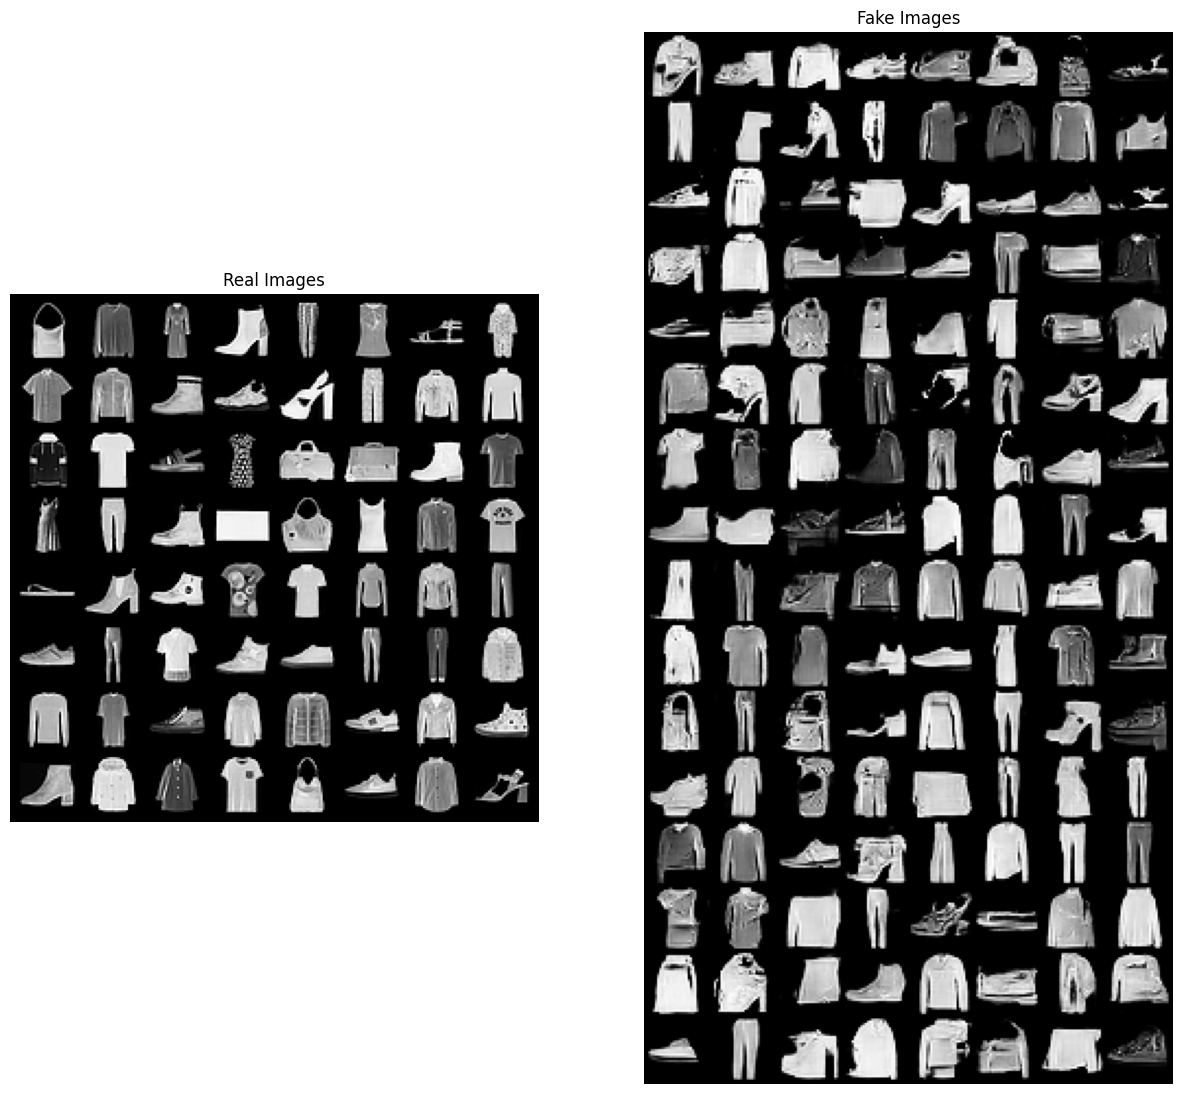

In [109]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()